In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def audtofreq(aud, scale="erb"):
    """
    Converts auditory units to frequency (Hz). Note that fs = 2.

    Parameters:
    aud (float or numpy array): Auditory scale value(s) to convert.
    scale (str): The auditory scale. Options are:
        - "mel": Mel scale
        - "erb": Equivalent Rectangular Bandwidth scale (default)
        - "bark": Bark scale
        - "log10": Base-10 logarithmic scale
        - "semitone": Semitone logarithmic scale

    Returns:
    float or numpy array: Frequency value(s) in Hz.
    """
    if scale == "mel":
        return 700 * np.sign(aud) * (np.exp(np.abs(aud) * np.log(17 / 7) / 1000) - 1)
    elif scale == "erb":
        return (1 / 0.00437) * np.sign(aud) * (np.exp(np.abs(aud) / 9.2645) - 1)
    elif scale == "bark":
        return np.sign(aud) * 1960 / (26.81 / (np.abs(aud) + 0.53) - 1)
    elif scale in ["log10", "semitone"]:
        return 10 ** aud
    else:
        raise ValueError(f"Unsupported scale: '{scale}'. Available options are: 'mel', 'erb', 'bark', 'log10', 'semitone'.")


In [3]:
def freqtoaud(freq, scale="erb"):
    """
    Converts frequencies (Hz) to auditory scale units.

    Parameters:
    freq (float or ndarray): Frequency value(s) in Hz.
    scale (str): Auditory scale. Supported values are:
                 - 'erb' (default)
                 - 'mel'
                 - 'bark'
                 - 'log10'

    Returns:
    float or ndarray: Corresponding auditory scale units.
    """

    scale = scale.lower()
    
    if scale == "mel":
        return 1000 / np.log(17 / 7) * np.sign(freq) * np.log(1 + np.abs(freq) / 700)

    elif scale == "mel1000":
        return 1000 / np.log(2) * np.sign(freq) * np.log(1 + np.abs(freq) / 1000)

    elif scale == "erb":
        # Glasberg and Moore's ERB scale
        return 9.2645 * np.sign(freq) * np.log(1 + np.abs(freq) * 0.00437)

    elif scale == "bark":
        # Bark scale from Traunmuller (1990)
        return np.sign(freq) * ((26.81 / (1 + 1960 / np.abs(freq))) - 0.53)

    elif scale == "erb83":
        # Moore et al. (1983) ERB scale
        return 11.17 * np.sign(freq) * (
            np.log((np.abs(freq) + 312) / (np.abs(freq) + 14675)) -
            np.log(312 / 14675)
        )
    elif scale in ["log10", "semitone"]:
        # Logarithmic scale
        return np.log10(freq)

    else:
        raise ValueError(f"Unsupported scale: '{scale}'. Available options are: 'mel', 'erb', 'bark', 'log10', 'semitone'.")


In [4]:
def audspace(fmin, fmax, n, scale="erb"):
    """
    Computes a vector of values equidistantly spaced on the selected auditory scale.

    Parameters:
    fmin (float): Minimum frequency in Hz.
    fmax (float): Maximum frequency in Hz.
    n (int): Number of points in the output vector.
    audscale (str): Auditory scale (default is 'erb').

    Returns:
    tuple:
        y (ndarray): Array of frequencies equidistantly scaled on the auditory scale.
        bw (float): Bandwidth between each sample on the auditory scale.
    """
    if not (isinstance(fmin, (int, float)) and np.isscalar(fmin)):
        raise ValueError("fmin must be a scalar.")
    
    if not (isinstance(fmax, (int, float)) and np.isscalar(fmax)):
        raise ValueError("fmax must be a scalar.")
    
    if not (isinstance(n, int) and n > 0):
        raise ValueError("n must be a positive integer scalar.")
    
    if fmin > fmax:
        raise ValueError("fmin must be less than or equal to fmax.")

    # Convert [fmin, fmax] to auditory scale
    audlimits = freqtoaud(np.array([fmin, fmax]), scale)

    # Generate frequencies spaced evenly on the auditory scale
    aud_space = np.linspace(audlimits[0], audlimits[1], n)
    y = audtofreq(aud_space, scale)

    # Calculate the bandwidth
    #bw = (audlimits[1] - audlimits[0]) / (n - 1)

    # Set exact endpoints
    y[0] = fmin
    y[-1] = fmax

    return y

In [5]:
def audfiltbw(fc, scale="erb"):
    """
    Computes the critical bandwidth of the auditory filter at a given center frequency.

    Parameters:
    fc (float or ndarray): Center frequency in Hz. Must be non-negative.
    audscale (str): Auditory scale. Supported values are:
                    - 'erb': Equivalent Rectangular Bandwidth (default)
                    - 'bark': Bark scale
                    - 'mel': Mel scale
                    - 'log10': Logarithmic scale
                    - 'semitone': Semitone scale

    Returns:
    ndarray or float: Critical bandwidth at each center frequency.
    """
    if isinstance(fc, (list, tuple)):
        fc = np.array(fc)
    if not (isinstance(fc, (float, int, np.ndarray)) and np.all(fc >= 0)):
        raise ValueError("fc must be a non-negative scalar or array.")

    # Compute critical bandwidth based on the auditory scale
    if scale == "erb":
        bw = 24.7 + fc / 9.265
    elif scale == "bark":
        bw = 25 + 75 * (1 + 1.4e-6 * fc**2)**0.69
    elif scale == "mel":
        bw = np.log(17 / 7) * (700 + fc) / 1000
    elif scale in ["log10", "semitone"]:
        bw = fc
    else:
        raise ValueError(f"Unsupported auditory scale: {scale}")

    return bw

In [6]:
def firwin(supp, Ls=None, name='hann'):
    """
    FIR window generation in Python.
    
    Parameters:
        name (str): Name of the window type.
        len (int or array-like): Length of the window or a vector for custom sampling points.
        
    Returns:
        g (ndarray): FIR window.
        info (dict): Metadata about the window.
    """
    if supp % 2 == 0:
        x = np.concatenate([np.linspace(0, 0.5 - 1/supp, supp//2), np.linspace(-0.5, -1/supp, supp//2)])
    else:
        x = np.concatenate([np.linspace(0, 0.5 - 0.5/supp, supp//2), np.linspace(-0.5 + 0.5/supp, -0.5/supp, supp//2)])
    
    x += supp//2 /supp

    g = 0.5 + 0.5 * np.cos(2 * np.pi * x)
    
    # L1 Normalization
    g /= np.sum(np.abs(g))
    #g /= np.max(np.abs(g))

    if Ls is None:
        if supp % 2 == 0:
            return g
        else:
            return np.concatenate([g, np.zeros(1)])
    
    if Ls > supp:
        return np.concatenate([g, np.zeros(Ls - len(g))])


In [7]:
def modulate(g, fc, fs):
    """Modulate a filters.
    
    Args:
        g (list of torch.Tensor): Filters.
        fc (list): Center frequencies.
        fs (int): Sampling rate.
    
    Returns:
        g_mod (list of torch.Tensor): Modulated filters.
    """
    Lg = len(g)
    g_mod = g * np.exp(2*np.pi*1j*fc*np.arange(Lg)/fs)
    return g_mod

In [8]:
def audfilters_fir(fs, Ls, fmin=0, fmax=None, spacing=1/2, bwmul=1, max_supp=480, redmul=1, scale='erb'):
    """
    Generate FIR filters equidistantly spaced on auditory frequency scales.
    
    Parameters:
        fs (int): Sampling rate.
        Ls (int): Signal length.
        fmin (int): Minimum frequency (Hz).
        fmax (int): Maximum frequency (Hz).
        spacing (float): Spacing between filters (scale units).
        bwmul (float): Bandwidth multiplier.
        max_supp (int): Maximum window length (samples).
        scale (str): Frequency scale ('erb', 'bark', 'mel', etc.).
    
    Returns:
        filters (list of torch.Tensor): Generated filters.
        a (list): Downsampling rates.
        fc (list): Center frequencies.
        L (int): Admissible signal length.
    """
    
    if fmax is None:
        fmax = fs // 2

    ####################################################################################################
    # Center frequencies
    ####################################################################################################

    # Compute center frequencies
    fmin = max(fmin, audtofreq(spacing))
    fmax = min(fmax, fs // 2)

    # Number of channels
    M0 = int(np.floor((freqtoaud(fmax)-freqtoaud(fmin)) / spacing))

    # Adjust fmax to match spacing
    fmax = audtofreq(freqtoaud(fmin) + M0 * spacing)

    # Ensure fmax < fs/2 and adjust the number of channels
    count = 0
    while fmax >= fs / 2:
        count += 1
        fmax = audtofreq(freqtoaud(fmin) + (M0 - count) * spacing)
    M0 -= count

    # Center frequencies are given as equidistantly spaced points on auditory scale
    fc = audspace(fmin, fmax, M0)
    fc = np.append(fc, fs // 2)  # Add fs//2 as the last frequency
    M2 = M0 + 1

    ####################################################################################################
    # Bandwith conversion factor
    ####################################################################################################

    probeLs = 10000
    probeLg = 1000

    # probe prototype window full length
    g_probe = firwin(probeLg,probeLs)

    # peak normalize
    gf_probe = np.fft.fft(g_probe)/np.max(np.abs(np.fft.fft(g_probe)))

    # compute ERB-type bandwidth of the prototype
    winbw = np.linalg.norm(gf_probe)**2*probeLg/probeLs/4

    ####################################################################################################
    # Frequency support
    ####################################################################################################

    # Frequency support measured in Hz
    fsupp = np.zeros(M2)
    fsupp[:M2-1] = audfiltbw(fc[:M2-1]) / winbw * bwmul

    # Optimal stride
    a = np.floor(np.min(fs / fsupp[:M2-1] / redmul)).astype(int)

    # next admissible signal length
    L = int(np.ceil(Ls / a) * a)

    ####################################################################################################
    # Time support
    ####################################################################################################

    # Calculate time supports -- Whats that factor 10.64??
    tsupp = (np.round(winbw / fsupp[:-1] * fs * 10.64)).astype(int)

    # Find all channels that need to be shortened
    ind_crit = np.where(tsupp[:-1] >= max_supp)[0]

    if ind_crit.size > 0:
        # Center frequency for the last valid channel
        fc_crit = fc[ind_crit[-1] + 1]

        # Frequency step from the previous to the last valid fc
        LP_step = fc[ind_crit[-1] + 2] - fc_crit

        # Number of bands needed
        LP_num = int(np.floor(fc_crit / LP_step))

        # Center frequencies of the low-pass and high-pass filters
        fc_high = fc[ind_crit[-1] + 1:]
        fc_low = np.flip(fc_high[0] - np.arange(1, LP_num + 1) * LP_step)
        fc_new = np.concatenate((fc_low, fc_high))

        tsuppmax = tsupp[ind_crit[-1] + 1]
        tsupp_low = np.ones(LP_num) * tsuppmax
        tsupp_high = tsupp[ind_crit[-1] + 1:]
        tsupp = np.concatenate((tsupp_low, tsupp_high)).astype(int)

    M2 = len(fc_new)-1
    ind = np.arange(1, M2)

    ####################################################################################################
    # Generate filters
    ####################################################################################################

    g = np.zeros((M2, fs), dtype=np.complex128)

    for m in ind:
        g[m,:] = np.sqrt(a) * modulate(np.roll(firwin(tsupp[m], fs), (fs-tsupp[m]) // 2), fc_new[m], fs)
        if m == 1:
            g[m,:] = g[m,:] / np.sqrt(2)

    return g, a, M2, fc_new, L, fc, fc_low, fc_high, ind_crit

In [27]:
fs = 16000
Ls = fs*5
fmin = 0
fmax = fs//2
spacing = 1/2
bwmul = 1
max_supp = 30
redmul = 1

[g,a,M,fc,L,fc_orig,fc_low,fc_high,ind_crit] = audfilters_fir(fs, Ls, max_supp = 480)


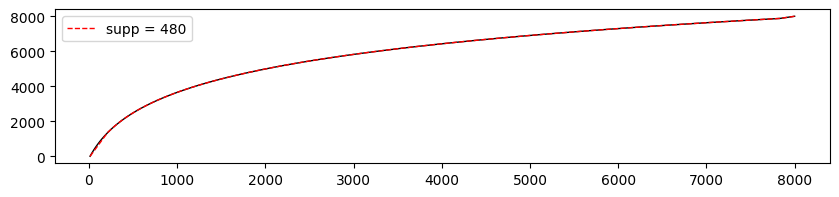

In [28]:
plt.figure(figsize=(10, 2))
fc_low2 = np.linspace(fc_orig[0], fc_low[-1], len(ind_crit))
fc_new2 = np.concatenate((fc_low2, fc_high))
plt.plot(fc_orig, np.linspace(0, 8000, len(fc_orig)), color='black', linewidth=1)
plt.plot(fc_new2, np.linspace(0, 8000, len(fc_new2)), linestyle='--', label='supp = 480', color='red', linewidth=1)
plt.legend()
plt.show()

(7730.0, 8270.0)

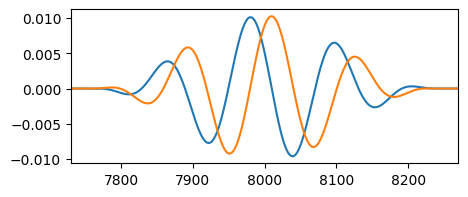

In [29]:
plt.figure(figsize=(5, 2))
plt.plot(np.real(g[5,:]))
plt.plot(np.imag(g[5,:]))
plt.xlim(8000-270,8000+270)

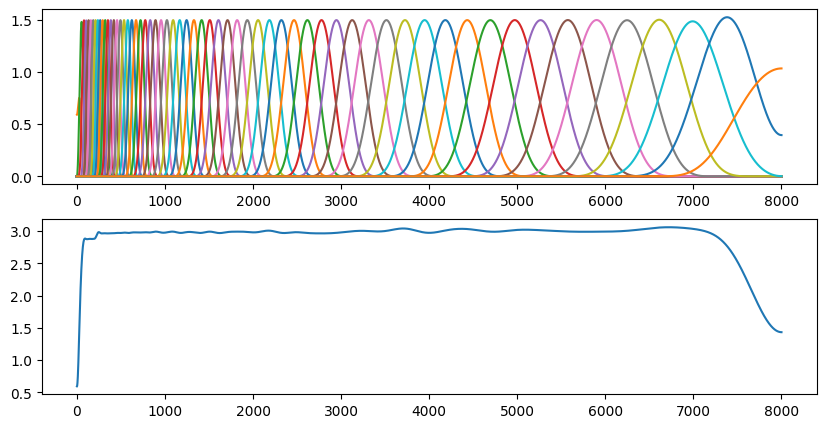

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))

axs[0].plot(np.abs(np.fft.rfft(g.real).T)**2)
axs[1].plot(np.sum(np.abs(np.fft.rfft(g.real,axis=1).T)**2,axis=1))
plt.show()